# GPU INITIALIZATION

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [1]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 3.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
!pip install tensorflow_decision_forests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 116.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 120.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 36.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Succes

# Préparation des données

In [1]:
import numpy as np
import pandas as pd
import re
import ast
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
from sentence_transformers import SentenceTransformer

import tensorflow as tf
# import tensorflow_decision_forests as tfdf

import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\cambo\AppData\Roaming\Python\Python311\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# path = 'drive/MyDrive/Master_Camp/'
path = 'data/'
df = pd.read_csv(path+'dataset_lipstip.csv', encoding='utf-8')

In [4]:
df.shape

(50000, 8)

In [5]:
df.head(2)

,Numéro d'application,Date d'application,Numero de publication,date de publication,CPC,IPC,claim,description
0,17167919,2017-04-25,3264223,2018-01-03,"['B23K26-361', 'H04M1-0266', 'B23K26-402', 'G0...","['C08J7-04', 'H04M1-02', 'G06F1-16', 'B23K26-3...","<!-- EPO <DP n=""18""> --><claim id=""c-en-0001"" ...","<!-- EPO <DP n=""1""> --><p id=""p0001"" num=""0001..."
1,17166775,2017-04-18,3235458,2017-10-25,"['A61B17-68', 'A61B17-888', 'A61B17-8685', 'A6...","['A61B17-88', 'A61B17-68', 'A61B17-86']","<!-- EPO <DP n=""20""> --><claim id=""c-en-0001"" ...","<!-- EPO <DP n=""1""> --><heading id=""h0001"">FIE..."


In [6]:
df.drop(columns = ["Numéro d'application", "Date d'application", "Numero de publication","date de publication","IPC",'description'], inplace=True)

In [7]:
df['CPC'] = df['CPC'].apply(lambda x: ast.literal_eval(x))

In [8]:
df.head(2)

,CPC,claim
0,"[B23K26-361, H04M1-0266, B23K26-402, G06F1-162...","<!-- EPO <DP n=""18""> --><claim id=""c-en-0001"" ..."
1,"[A61B17-68, A61B17-888, A61B17-8685, A61B17-86...","<!-- EPO <DP n=""20""> --><claim id=""c-en-0001"" ..."


In [9]:
print(df['CPC'][0])

['B23K26-361', 'H04M1-0266', 'B23K26-402', 'G06F1-1626', 'G06F1-1656', 'G06F1-1637', 'G02F1-133308', 'B23K2101-34', 'B23K2101-40', 'B23K2103-42', 'B23K2103-172', 'G02F1-133331']


In [10]:
df['claim'][0]

'<!-- EPO <DP n="18"> --><claim id="c-en-0001" num="0001"><claim-text>A method of manufacturing a cover window for a display panel, comprising:<claim-text>forming a first coating layer (120) on an upper surface of a plastic layer (110);</claim-text><claim-text>performing mechanical processing on an edge of the plastic layer (110) and an edge of the first coating layer (120) to produce a desired shape; and</claim-text><claim-text>performing laser processing on the edge of the first coating layer after performing the mechanical processing.</claim-text></claim-text></claim><claim id="c-en-0002" num="0002"><claim-text>The method of claim 1, wherein an edge of the cover window includes:<claim-text>a side part (310) perpendicular to the upper surface of the plastic layer;</claim-text><claim-text>a first inclined part (320) extending from the side part (310);</claim-text><claim-text>a first parallel part extending from the first inclined part parallel to the upper surface of the plastic layer

In [11]:
df['claim'] = df['claim'].apply(lambda x: re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '<MAIL>', x))
df['claim'] = df['claim'].apply(lambda x: re.sub(r'(http|https|ftp)://[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}(\/\S*)?', '<URL>', x))
df['claim'] = df['claim'].apply(lambda x: re.sub(r'\(\d+\)', '<CITATION>', x))
df['claim'] = df['claim'].apply(lambda x: re.sub(r'\<\/p>\<p id=""p\d*"" num=""\d*"">', '<NOUVEAU PARAGRAPHE>', x))
df['claim'] = df['claim'].apply(lambda x: re.sub(r'<!-- EPO <DP n="\d*"> -->', '<NOUVELLE PAGE>', x))
df['claim'] = df['claim'].apply(lambda x: re.sub(r'<!-- EPO <DP n=""\d*""> -->', '<NOUVELLE PAGE>', x))
df['claim'] = df['claim'].apply(lambda x: re.sub(r'<[^>A-Z]*>', '', x))

In [12]:
df['claim'][0]

'<NOUVELLE PAGE>A method of manufacturing a cover window for a display panel, comprising:forming a first coating layer <CITATION> on an upper surface of a plastic layer <CITATION>;performing mechanical processing on an edge of the plastic layer <CITATION> and an edge of the first coating layer <CITATION> to produce a desired shape; andperforming laser processing on the edge of the first coating layer after performing the mechanical processing.The method of claim 1, wherein an edge of the cover window includes:a side part <CITATION> perpendicular to the upper surface of the plastic layer;a first inclined part <CITATION> extending from the side part <CITATION>;a first parallel part extending from the first inclined part parallel to the upper surface of the plastic layer; anda second inclined part <CITATION> extending from the first horizontal part to the upper surface of the plastic layer, andwherein the side part <CITATION> and the first inclined part <CITATION> are formed by mechanical

In [13]:
df.head(2)

,CPC,claim
0,"[B23K26-361, H04M1-0266, B23K26-402, G06F1-162...",<NOUVELLE PAGE>A method of manufacturing a cov...
1,"[A61B17-68, A61B17-888, A61B17-8685, A61B17-86...",<NOUVELLE PAGE>A compression screw for applyin...


In [14]:
from sklearn.preprocessing import MultiLabelBinarizer

df['CPC'] = df['CPC'].apply(lambda x:[a[0] for a in x])
df['CPC'] = df['CPC'].apply(lambda x:pd.Series(x).unique())

mlb = MultiLabelBinarizer(sparse_output=True)

df_cpc_splited = df.join(pd.DataFrame.sparse.from_spmatrix(mlb.fit_transform(df.pop('CPC')),
                                                           index=df.index,
                                                           columns=mlb.classes_
                                                           ))

In [15]:
df_cpc_splited.head()

,claim,A,B,C,D,E,F,G,H,Y
0,<NOUVELLE PAGE>A method of manufacturing a cov...,0,1,0,0,0,0,1,1,0
1,<NOUVELLE PAGE>A compression screw for applyin...,1,0,0,0,0,0,0,0,0
2,<NOUVELLE PAGE>A clothes dryer <CITATION> comp...,0,0,0,1,0,0,0,0,0
3,<NOUVELLE PAGE>A diplexer comprising:a filter ...,0,0,0,0,0,0,0,1,0
4,<NOUVELLE PAGE>A method for displaying an Elec...,0,0,0,0,0,0,0,1,0


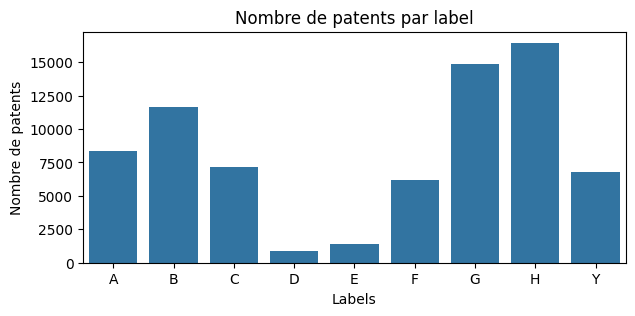

In [16]:
# Crée une Pandas Series qui contient la somme de chaque colonne dans un vecteur colonne ou chaque ligne correspond aux colonnes (labels) du DataFrame
labels_means = df_cpc_splited.iloc[:, 1:].sum()

plt.figure(figsize=(7, 3))
sns.barplot(x=labels_means.index, y=labels_means.values)
plt.xlabel('Labels')
plt.ylabel('Nombre de patents')
plt.title('Nombre de patents par label')
plt.show()

# Random forest

In [19]:
def classificationReport(all_reports):
    # Permet d'avoir la classification report moyenne des Kfolds. On obtient donc un critère de performence non-biaisé
    average_metrics = {}
    metrics = ['precision', 'recall', 'f1-score', 'support']
    for metric in metrics:
        average_metrics[metric] = {label: np.mean([fold[label][metric] for fold in all_reports]) for label in all_reports[0]}
    return pd.DataFrame(average_metrics)

def confusionMatrixTotal(labels_test, labels_predicted):
    cm = confusion_matrix(labels_test.ravel(), labels_predicted.ravel())
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=np.unique(labels_test), yticklabels=np.unique(labels_test))
    plt.xlabel('Classe Prédite')
    plt.ylabel('Classe Réelle')
    plt.title('Matrice de Confusion')
    plt.show()

def confusionMatrixClasses(labels_test, labels_predicted, labels_names):
    nb_labels = labels_test.shape[1]
    nb_samples = labels_test.shape[0]

    # On initialise la matrice de confusion avec des zéros
    cm = np.zeros((nb_labels, nb_labels), dtype=int)
    
    for true in range(nb_labels-1, -1, -1):
        for pred in range(nb_labels):
            for sample in range(nb_samples):
                if labels_test[sample, true] == 1 and labels_predicted[sample, pred] == 1:
                    cm[true, pred] +=1

    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=labels_names, yticklabels=labels_names)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    plt.xlabel('Classe Prédite')
    plt.ylabel('Classe Réelle')
    plt.title('Matrice de Confusion')
    plt.show()

In [20]:
labels = df_cpc_splited.iloc[:, 1:]
labels = np.array(labels)
labels_names = df_cpc_splited.iloc[:, 1:].columns
df_claim = df_cpc_splited['claim']

## Split normal

In [21]:
# On sépare les données de train et de test de façon aléatoire
claim_train, claim_test, labels_train, labels_test = train_test_split(df_claim, labels, test_size=0.2, random_state=42)

### RandomForestClassifier (Scikit-Learn) + TF-IDF

In [23]:
# On fait l'embedding du texte grâce à la méthode TF-IDF qui calcule la fréquence d'appariton des tokens d'un patent en le comparent avec ceux du corpus. On ne garde ici que les 5000 tokens les plus fréquents
vectorizer = TfidfVectorizer(max_features=5000)
claim_vectorized_train = vectorizer.fit_transform(claim_train)
claim_vectorized_test = vectorizer.fit_transform(claim_test)

In [25]:
print(claim_vectorized_train.shape)

(40000, 5000)


In [26]:
print(claim_vectorized_test.shape)

(10000, 5000)


In [ ]:
# On initialise notre mod_le random forest avec 100 arbres de décisions
rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1) # ajouter verbose=1 pour voir le détail de l'entrainement

# On utilise le random forest sur une classification multiclass avec un multi-input et multi-output. On utilise ici 1 seul coeur du CPU
multi_target_rf_Tfidf = MultiOutputClassifier(rf, n_jobs=1)

# On entraine le model sur les données d'entrainement
multi_target_rf_Tfidf.fit(claim_vectorized_train, labels_train,)

In [ ]:
#sérialise l'objet
joblib.dump(multi_target_rf_Tfidf, path+'rf_Sklearn_Tfidf_50K.plk')

In [189]:
multi_target_rf_Tfidf = joblib.load(path+'rf_Sklearn_Tfidf_50K.plk')

In [190]:
# On fait prédire le modèle sur les données de test
labels_predicted = multi_target_rf_Tfidf.predict(claim_vectorized_test)

print("Classification report :")
print(classification_report(labels_test, labels_predicted, target_names=labels_names))

Classification report :
              precision    recall  f1-score   support

           A       0.17      0.39      0.24      1662
           B       0.31      0.10      0.15      2335
           C       0.26      0.04      0.06      1464
           D       0.00      0.00      0.00       160
           E       0.00      0.00      0.00       254
           F       0.07      0.00      0.01      1257
           G       0.39      0.10      0.16      3004
           H       0.33      0.13      0.19      3213
           Y       0.20      0.01      0.01      1363

   micro avg       0.24      0.11      0.15     14712
   macro avg       0.19      0.09      0.09     14712
weighted avg       0.27      0.11      0.13     14712
 samples avg       0.13      0.12      0.12     14712



c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


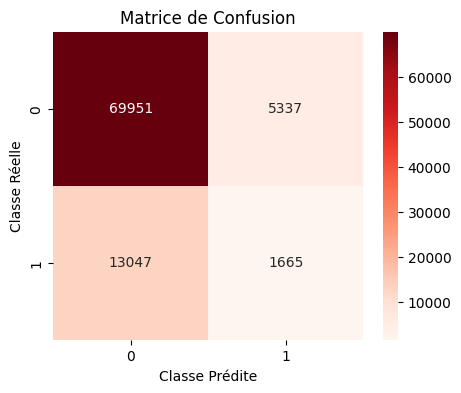

In [191]:
confusionMatrixTotal(labels_test, labels_predicted)

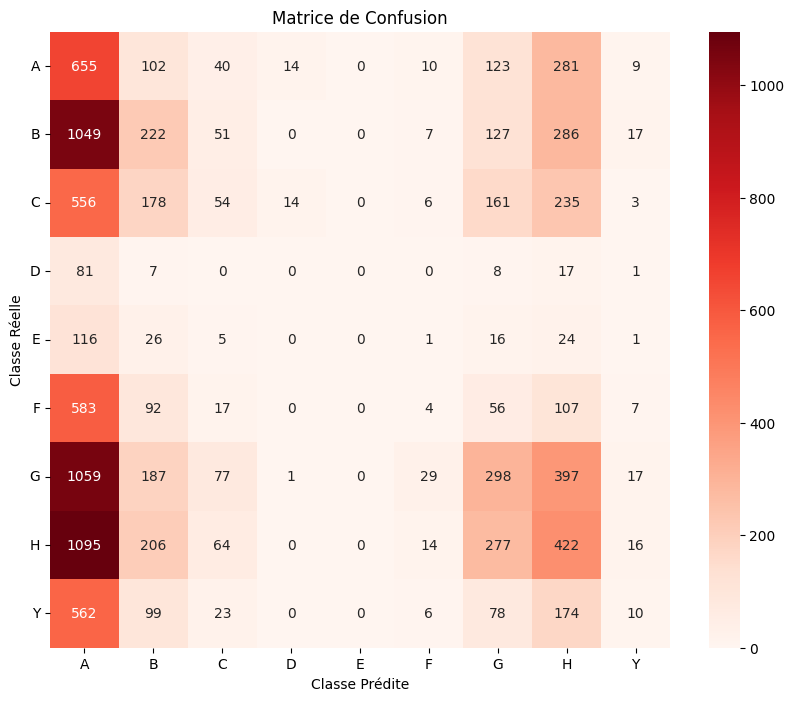

In [192]:
confusionMatrixClasses(labels_test, labels_predicted, labels_names)


### PatentSBERTa (sentence_transformers)

In [ ]:
sentenceList_train = list(claim_train)
sentenceList_test = list(claim_test)

# On fait l'embedding des données de train et de test grâce à PatentSBERTa
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')
claim_embeddings_train = model.encode(sentenceList_train, convert_to_tensor=True, show_progress_bar=True)
claim_embeddings_test = model.encode(sentenceList_test, convert_to_tensor=True, show_progress_bar=True)

In [ ]:
torch.save(claim_embeddings_train, path+'claim_embeddings_train.pt')
torch.save(claim_embeddings_test, path+'claim_embeddings_test.pt')

In [22]:
claim_embeddings_train = torch.load(path+'claim_embeddings_train.pt', map_location=torch.device('cpu'))
claim_embeddings_test = torch.load(path+'claim_embeddings_test.pt', map_location=torch.device('cpu'))

#### RandomForestClassifer (Scikit-Learn)

In [171]:
# On initialise notre mod_le random forest avec 100 arbres de décisions
rf = RandomForestClassifier(n_estimators=100, criterion='log_loss', max_features='sqrt',random_state=42, verbose=1)

# On utilise le random forest sur une classification multiclass avec un multi-input et multi-output
multi_target_rf_PBerta = MultiOutputClassifier(rf, n_jobs=1)

# On entraine le model sur les données d'entrainement
multi_target_rf_PBerta.fit(claim_embeddings_train, labels_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.9min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.7min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.9min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.6min


MultiOutputClassifier(estimator=RandomForestClassifier(criterion='log_loss',
                                                       random_state=42,
                                                       verbose=1),
                      n_jobs=1)

In [ ]:
#sérialise l'objet
joblib.dump(multi_target_rf_PBerta, path+'rf_Sklearn_PatentSBERTa_50K_100Arbres_sqrt_log-loss.plk')

In [150]:
multi_target_rf_PBerta = joblib.load(path+'rf_Sklearn_PatentSBERTa_50K_100Arbres_sqrt_log-loss.plk')

In [172]:
# On fait prédire le modèle sur les données de test
labels_predicted = multi_target_rf_PBerta.predict(claim_embeddings_test)

print("Classification report :")
print(classification_report(labels_test, labels_predicted, target_names=labels_names))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


Classification report :
              precision    recall  f1-score   support

           A       0.92      0.29      0.44      1662
           B       0.90      0.25      0.39      2335
           C       0.84      0.68      0.75      1464
           D       1.00      0.07      0.13       160
           E       1.00      0.01      0.02       254
           F       0.88      0.33      0.48      1257
           G       0.82      0.60      0.69      3004
           H       0.88      0.63      0.73      3213
           Y       0.91      0.21      0.35      1363

   micro avg       0.86      0.45      0.59     14712
   macro avg       0.90      0.34      0.44     14712
weighted avg       0.88      0.45      0.56     14712
 samples avg       0.58      0.50      0.52     14712



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


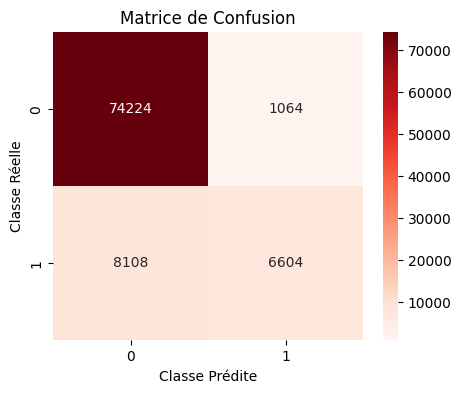

In [85]:
confusionMatrixTotal(labels_test, labels_predicted)

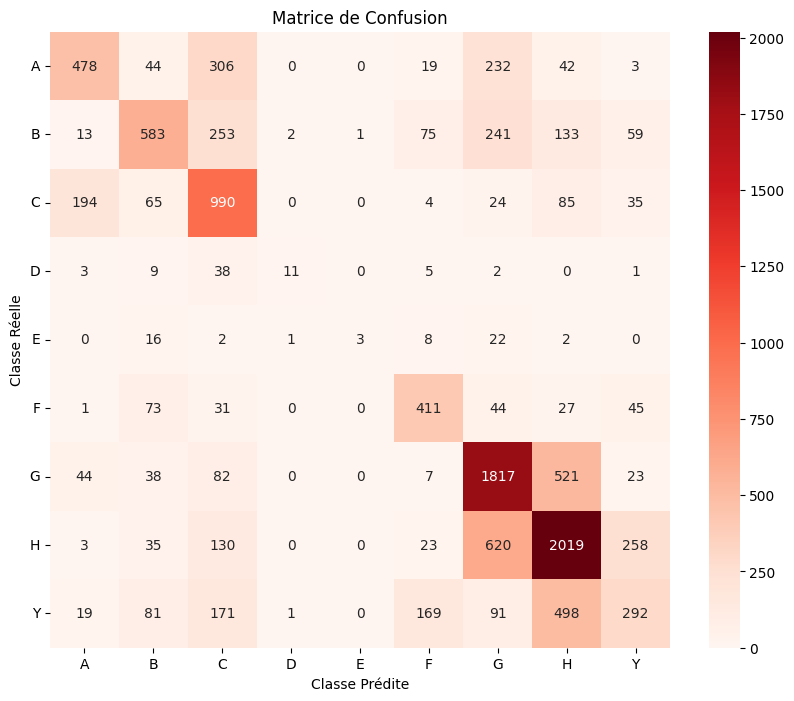

In [188]:
confusionMatrixClasses(labels_test, labels_predicted, labels_names)

#### RandomForestModel (Tensorflow_decision_forests)

In [27]:
claim_embeddings_train_df = pd.DataFrame(claim_embeddings_train.numpy(), columns=[f'feature_{i}' for i in range(claim_embeddings_train.shape[1])])
claim_embeddings_test_df = pd.DataFrame(claim_embeddings_test.numpy(), columns=[f'feature_{i}' for i in range(claim_embeddings_test.shape[1])])


labels_train_df = pd.DataFrame(labels_train, columns=labels_names)
labels_test_df = pd.DataFrame(labels_test, columns=labels_names)

train_df = pd.concat([claim_embeddings_train_df, labels_train_df['H']], axis=1)
test_df = pd.concat([claim_embeddings_test_df, labels_test_df['H']], axis=1)

# Conversion en TensorFlow Dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label='H')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label='H')

In [28]:
# Créer et entraîner le modèle Random Forest
model = tfdf.keras.RandomForestModel(num_trees=300, random_seed=42 ,verbose=2)
model.fit(train_ds)

# Évaluer le modèle
evaluation = model.evaluate(test_ds)
print(evaluation)

# Faire des prédictions
predictions = model.predict(test_ds)

Use 8 thread(s) for training
Use /tmp/tmpxnfc8ljp as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'feature_0': <tf.Tensor 'data:0' shape=(None,) dtype=float32>, 'feature_1': <tf.Tensor 'data_1:0' shape=(None,) dtype=float32>, 'feature_2': <tf.Tensor 'data_2:0' shape=(None,) dtype=float32>, 'feature_3': <tf.Tensor 'data_3:0' shape=(None,) dtype=float32>, 'feature_4': <tf.Tensor 'data_4:0' shape=(None,) dtype=float32>, 'feature_5': <tf.Tensor 'data_5:0' shape=(None,) dtype=float32>, 'feature_6': <tf.Tensor 'data_6:0' shape=(None,) dtype=float32>, 'feature_7': <tf.Tensor 'data_7:0' shape=(None,) dtype=float32>, 'feature_8': <tf.Tensor 'data_8:0' shape=(None,) dtype=float32>, 'feature_9': <tf.Tensor 'data_9:0' shape=(None,) dtype=float32>, 'feature_10': <tf.Tensor 'data_10:0' shape=(None,) dtype=float32>, 'feature_11': <tf.Tensor 'data_11:0' shape=(None,) dtype=float32>, 'feature_12': <tf.Tensor 'data_12:0' shape=(None,) dtype=float32>, 'fea

[INFO 24-07-02 14:06:01.5197 UTC kernel.cc:771] Start Yggdrasil model training
[INFO 24-07-02 14:06:01.5197 UTC kernel.cc:772] Collect training examples
[INFO 24-07-02 14:06:01.5198 UTC kernel.cc:785] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 24-07-02 14:06:01.5216 UTC kernel.cc:391] Number of batches: 40
[INFO 24-07-02 14:06:01.5216 UTC kernel.cc:392] Number of examples: 40000
[INFO 24-07-02 14:06:01.8104 UTC kernel.cc:792] Training dataset:
Number of records: 40000
Number of columns: 769

Number of columns by type:
	NUMERICAL: 768 (99.87%)
	CATEGORICAL: 1 (0.130039%)

Columns:

NUMERICAL: 768 (99.87%)
	1: "feature_0" NUMERICAL mean:0.0715229 min:-0.54699

Model trained in 0:01:18.952000
Compiling model...
Model compiled.
10/10 [==============================] - 6s 473ms/step - loss: 0.0000e+00
0.0
10/10 [==============================] - 5s 483ms/step


In [29]:
predicted_labels = pd.DataFrame(predictions, columns=['H'])
predicted_labels_discrete = predicted_labels['H'].round().astype(int)
nombre_de_uns = np.count_nonzero(labels_train[:,7] == 1)
nombre_de_uns = np.count_nonzero(predicted_labels_discrete == 1)

In [30]:
# Générer un rapport de classification
print("Classification report :")
print(classification_report(labels_test[:,7], predicted_labels_discrete, target_names=['non H', 'H']))

Classification report :
              precision    recall  f1-score   support

       non H       0.85      0.96      0.90      6787
           H       0.89      0.63      0.74      3213

    accuracy                           0.86     10000
   macro avg       0.87      0.80      0.82     10000
weighted avg       0.86      0.86      0.85     10000



## Cross validation

### Random Forest Scikit-Learn + TF-IDF

In [ ]:

# On initialise notre mod_le random forest
rf = RandomForestClassifier(n_estimators=100, criterion='log_loss', max_features='sqrt',random_state=42, verbose=1)

# On utilise le random forest sur une classification multiclass avec un multi-input et multi-output
multi_target_rf_Tfidf = MultiOutputClassifier(rf, n_jobs=1)

# On initialise la méthode des Kfold pour séparer notre dataset en 5 partitions (fold) aléatoires différentes
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# On fait l'embedding du texte grâce à la méthode TF-IDF qui calcule la fréquence d'appariton des tokens d'un patent en le comparent avec ceux du corpus. On ne garde ici que les 5000 tokens les plus fréquents
vectorizer = TfidfVectorizer(max_features=5000)

all_reports = []

#On sépare ici les données de successivement en récuprérant les indexs des échantillons à prendre
for i, (train_index, test_index) in enumerate(kf.split(df_claim, labels), start=1):

    # Vectorisation avec TF-IDF
    claim_vectorized_train = vectorizer.fit_transform(df_claim[train_index])
    claim_vectorized_test = vectorizer.fit_transform(df_claim[test_index])

    labels_train, labels_test = labels[train_index], labels[test_index]

    # On entraine le model sur les données d'entrainement de ce fold
    multi_target_rf_Tfidf.fit(claim_vectorized_train, labels_train)

    # On fait prédire le modèle sur les données de test de ce fold
    labels_predicted = multi_target_rf_Tfidf.predict(claim_vectorized_test)

    print(f"\nFold n°{i} classification report :")
    print(classification_report(labels_test, labels_predicted, target_names=labels_names))
    all_reports.append(classification_report(labels_test, labels_predicted, target_names=labels_names, output_dict=True))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   47.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   54.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   28.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   16.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   19.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   35.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   51.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   53.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   47.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do


Fold n°1 classification report :
              precision    recall  f1-score   support

           A       0.15      0.28      0.20      1662
           B       0.29      0.02      0.03      2335
           C       0.33      0.00      0.00      1464
           D       0.00      0.00      0.00       160
           E       0.00      0.00      0.00       254
           F       0.00      0.00      0.00      1257
           G       0.42      0.01      0.01      3004
           H       0.24      0.04      0.06      3213
           Y       0.04      0.00      0.00      1363

   micro avg       0.17      0.04      0.07     14712
   macro avg       0.16      0.04      0.03     14712
weighted avg       0.24      0.04      0.05     14712
 samples avg       0.06      0.05      0.05     14712



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Fold n°2 classification report :
              precision    recall  f1-score   support

           A       0.22      0.27      0.24      1750
           B       0.32      0.03      0.05      2298
           C       0.14      0.00      0.01      1444
           D       0.00      0.00      0.00       186
           E       0.00      0.00      0.00       285
           F       0.92      0.01      0.02      1238
           G       0.54      0.01      0.03      2940
           H       0.35      0.04      0.08      3250
           Y       0.07      0.00      0.00      1340

   micro avg       0.25      0.05      0.08     14731
   macro avg       0.28      0.04      0.05     14731
weighted avg       0.36      0.05      0.06     14731
 samples avg       0.07      0.06      0.06     14731



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Fold n°3 classification report :
              precision    recall  f1-score   support

           A       0.21      0.15      0.18      1642
           B       0.39      0.11      0.17      2354
           C       0.88      0.02      0.03      1424
           D       0.00      0.00      0.00       171
           E       0.00      0.00      0.00       273
           F       0.14      0.00      0.00      1278
           G       0.54      0.02      0.03      2900
           H       0.58      0.17      0.27      3328
           Y       0.37      0.03      0.06      1339

   micro avg       0.39      0.08      0.13     14709
   macro avg       0.35      0.05      0.08     14709
weighted avg       0.46      0.08      0.12     14709
 samples avg       0.11      0.09      0.09     14709



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Fold n°4 classification report :
              precision    recall  f1-score   support

           A       0.21      0.20      0.20      1616
           B       0.43      0.03      0.06      2297
           C       0.76      0.14      0.23      1428
           D       0.00      0.00      0.00       178
           E       0.00      0.00      0.00       311
           F       0.32      0.01      0.01      1187
           G       0.74      0.06      0.11      2999
           H       0.57      0.11      0.19      3353
           Y       0.21      0.01      0.01      1328

   micro avg       0.40      0.08      0.13     14697
   macro avg       0.36      0.06      0.09     14697
weighted avg       0.49      0.08      0.12     14697
 samples avg       0.11      0.08      0.09     14697



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif


Fold n°5 classification report :
              precision    recall  f1-score   support

           A       0.14      0.34      0.20      1651
           B       0.34      0.03      0.05      2345
           C       0.44      0.01      0.01      1412
           D       0.00      0.00      0.00       182
           E       0.00      0.00      0.00       253
           F       0.00      0.00      0.00      1261
           G       0.40      0.01      0.02      2980
           H       0.38      0.18      0.24      3303
           Y       0.16      0.02      0.04      1384

   micro avg       0.22      0.09      0.12     14771
   macro avg       0.21      0.06      0.06     14771
weighted avg       0.29      0.09      0.09     14771
 samples avg       0.11      0.09      0.09     14771



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
classificationReport(all_reports)

,precision,recall,f1-score,support
A,0.188118,0.246853,0.203945,1664.2
B,0.353356,0.041883,0.071790,2325.8
C,0.513327,0.032779,0.057087,1434.4
D,0.000000,0.000000,0.000000,175.4
E,0.000000,0.000000,0.000000,275.2
F,0.273764,0.003257,0.006433,1244.2
G,0.529168,0.020366,0.038635,2964.6
H,0.423023,0.108921,0.167903,3289.4
Y,0.171174,0.012395,0.022573,1350.8
micro avg,0.286324,0.067800,0.108213,14724.0


### Random Forest Scikit-Learn + PatentSBERTa

In [ ]:
# On initialise la méthode des Kfold pour séparer notre dataset en 5 partitions (fold) aléatoires différentes
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# On initialise le modèle PatentSBERTa de la librairie sentence-transformers
model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

#On sépare ici les données de successivement en récuprérant les indexs des échantillons à prendre
for i, (train_index, test_index) in enumerate(kf.split(df_claim, labels), start=1):

    sentenceList_train = list(df_claim[train_index])
    sentenceList_test = list(df_claim[test_index])

    # On fait l'embedding des données de train et de test grâce à PatentSBERTa
    claim_embeddings_train = model.encode(sentenceList_train, convert_to_tensor=True, show_progress_bar=True)
    claim_embeddings_test = model.encode(sentenceList_test, convert_to_tensor=True, show_progress_bar=True)

    labels_train, labels_test = labels[train_index], labels[test_index]

    torch.save(claim_embeddings_train, path+'claim_embeddings_train'+str(i)+'.pt')
    torch.save(claim_embeddings_test, path+'claim_embeddings_test'+str(i)+'.pt')

    joblib.dump(labels_train, path+'labels_train'+str(i)+'.plk')
    joblib.dump(labels_test, path+'labels_test'+str(i)+'.plk')

pytorch_model.bin:  29%|##8       | 126M/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Batches:   0%|          | 0/1250 [00:00<?, ?it/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
# On initialise notre mod_le random forest
rf = RandomForestClassifier(n_estimators=100, criterion='log_loss', max_features='sqrt',random_state=42, verbose=1)

# On utilise le random forest sur une classification multiclass avec un multi-input et multi-output
multi_target_rf = MultiOutputClassifier(rf, n_jobs=1)

all_reports = []

for i in range(1,6):
    claim_embeddings_train = torch.load(path+'claim_embeddings_train'+str(i)+'.pt', map_location=torch.device('cpu'))
    claim_embeddings_test = torch.load(path+'claim_embeddings_test'+str(i)+'.pt', map_location=torch.device('cpu'))

    labels_train = joblib.load(path+'labels_train'+str(i)+'.plk')
    labels_test = joblib.load(path+'labels_test'+str(i)+'.plk')

    # On entraine le model sur les données d'entrainement de ce fold
    multi_target_rf.fit(claim_embeddings_train, labels_train)

    # On fait prédire le modèle sur les données de test de ce fold
    labels_predicted = multi_target_rf.predict(claim_embeddings_test)

    print(f"\nFold n°{i} classification report :")
    print(classification_report(labels_test, labels_predicted, target_names=labels_names))
    all_reports.append(classification_report(labels_test, labels_predicted, target_names=labels_names, output_dict=True))


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   53.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do


Fold n°1 classification report :
              precision    recall  f1-score   support

           A       0.92      0.28      0.43      1662
           B       0.88      0.24      0.38      2335
           C       0.84      0.70      0.76      1464
           D       0.91      0.06      0.12       160
           E       1.00      0.01      0.02       254
           F       0.89      0.33      0.48      1257
           G       0.82      0.61      0.70      3004
           H       0.88      0.63      0.74      3213
           Y       0.91      0.21      0.34      1363

   micro avg       0.86      0.45      0.59     14712
   macro avg       0.90      0.34      0.44     14712
weighted avg       0.88      0.45      0.56     14712
 samples avg       0.59      0.50      0.52     14712



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   55.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=


Fold n°2 classification report :
              precision    recall  f1-score   support

           A       0.95      0.28      0.43      1750
           B       0.88      0.26      0.40      2298
           C       0.82      0.67      0.74      1444
           D       0.95      0.11      0.19       186
           E       0.00      0.00      0.00       285
           F       0.90      0.34      0.50      1238
           G       0.81      0.60      0.69      2940
           H       0.87      0.62      0.72      3250
           Y       0.91      0.20      0.32      1340

   micro avg       0.86      0.44      0.58     14731
   macro avg       0.79      0.34      0.44     14731
weighted avg       0.86      0.44      0.56     14731
 samples avg       0.58      0.49      0.51     14731



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   53.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(


Fold n°3 classification report :
              precision    recall  f1-score   support

           A       0.94      0.28      0.43      1642
           B       0.85      0.26      0.40      2354
           C       0.84      0.65      0.73      1424
           D       0.91      0.06      0.11       171
           E       1.00      0.01      0.01       273
           F       0.92      0.32      0.48      1278
           G       0.81      0.61      0.69      2900
           H       0.89      0.61      0.72      3328
           Y       0.89      0.20      0.33      1339

   micro avg       0.86      0.44      0.58     14709
   macro avg       0.89      0.33      0.44     14709
weighted avg       0.87      0.44      0.56     14709
 samples avg       0.57      0.49      0.51     14709



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   52.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=


Fold n°4 classification report :
              precision    recall  f1-score   support

           A       0.93      0.30      0.45      1616
           B       0.85      0.26      0.39      2297
           C       0.82      0.68      0.74      1428
           D       1.00      0.08      0.16       178
           E       1.00      0.01      0.01       311
           F       0.90      0.32      0.47      1187
           G       0.81      0.58      0.68      2999
           H       0.87      0.61      0.72      3353
           Y       0.91      0.20      0.32      1328

   micro avg       0.85      0.44      0.58     14697
   macro avg       0.90      0.34      0.44     14697
weighted avg       0.87      0.44      0.56     14697
 samples avg       0.58      0.49      0.51     14697



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   52.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=


Fold n°5 classification report :
              precision    recall  f1-score   support

           A       0.93      0.28      0.43      1651
           B       0.84      0.23      0.36      2345
           C       0.84      0.67      0.75      1412
           D       1.00      0.08      0.15       182
           E       1.00      0.01      0.02       253
           F       0.90      0.36      0.52      1261
           G       0.81      0.61      0.69      2980
           H       0.88      0.62      0.73      3303
           Y       0.87      0.18      0.30      1384

   micro avg       0.85      0.44      0.58     14771
   macro avg       0.90      0.34      0.44     14771
weighted avg       0.87      0.44      0.55     14771
 samples avg       0.58      0.50      0.52     14771



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
classificationReport(all_reports)

,precision,recall,f1-score,support
A,0.933004,0.281584,0.432541,1664.2
B,0.860816,0.249681,0.386917,2325.8
C,0.831590,0.674460,0.744728,1434.4
D,0.954113,0.079039,0.145562,175.4
E,0.800000,0.005907,0.011727,275.2
F,0.904144,0.335659,0.489318,1244.2
G,0.811853,0.602334,0.691513,2964.6
H,0.879508,0.617851,0.725761,3289.4
Y,0.897336,0.196970,0.322969,1350.8
micro avg,0.856865,0.443739,0.584684,14724.0


In [2]:
import torch